In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [3]:
# Paths to CSV files
train_img_csv = "./MURA-v1.1/MURA-v1.1/train_image_paths.csv"
valid_img_csv = "./MURA-v1.1/MURA-v1.1/valid_image_paths.csv"
train_study_csv = "./MURA-v1.1/MURA-v1.1/train_labeled_studies.csv"
valid_study_csv = "./MURA-v1.1/MURA-v1.1/valid_labeled_studies.csv"

# Read CSV files
train_paths = pd.read_csv(train_img_csv, header=None)
valid_paths = pd.read_csv(valid_img_csv, header=None)

# Convert labels from study-level to image-level
def get_label_from_path(path):
    return 1 if "positive" in path else 0

# Apply label extraction
train_paths["label"] = train_paths[0].apply(get_label_from_path)
valid_paths["label"] = valid_paths[0].apply(get_label_from_path)

# Convert paths to full paths
train_paths[0] = train_paths[0].apply(lambda x: os.path.join("./MURA-v1.1/", x))
valid_paths[0] = valid_paths[0].apply(lambda x: os.path.join("./MURA-v1.1/", x))


In [4]:
class MURADataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]

        # Load image
        image = Image.open(img_path).convert("RGB")
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Define image transformations
img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

valid_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Create datasets
train_dataset = MURADataset(train_paths, transform=train_transform)
valid_dataset = MURADataset(valid_paths, transform=valid_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [5]:
from torchvision.models import ResNet50_Weights

# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  

# Modify final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [6]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = torch.round(torch.sigmoid(outputs))
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")


Epoch [1/10], Loss: 0.4942, Accuracy: 0.7709
Epoch [2/10], Loss: 0.4382, Accuracy: 0.8102
Epoch [3/10], Loss: 0.4091, Accuracy: 0.8264
Epoch [4/10], Loss: 0.3789, Accuracy: 0.8428
Epoch [5/10], Loss: 0.3439, Accuracy: 0.8576
Epoch [6/10], Loss: 0.3053, Accuracy: 0.8766
Epoch [7/10], Loss: 0.2637, Accuracy: 0.8949
Epoch [8/10], Loss: 0.2202, Accuracy: 0.9144
Epoch [9/10], Loss: 0.1811, Accuracy: 0.9303
Epoch [10/10], Loss: 0.1493, Accuracy: 0.9432


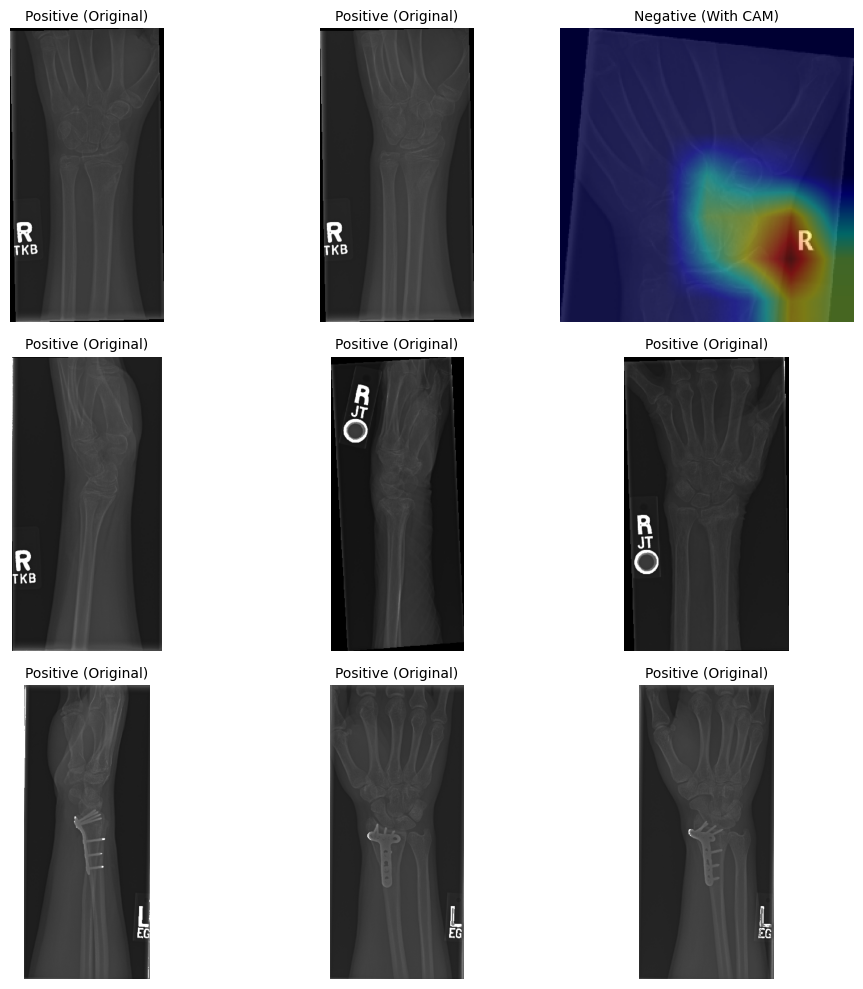

In [7]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Define function to compute CAM
def compute_cam(model, img_tensor, layer_name="layer4"):
    model.eval()
    
    feature_maps = None
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    # Hook the selected layer
    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        output = model(img_tensor)

    handle.remove()

    # Get predicted class
    predicted_class = torch.round(torch.sigmoid(output)).item()

    if predicted_class == 1:  # Positive case, return original image
        return None, predicted_class

    # Get weight of final layer
    weights = model.fc.weight.detach().cpu().numpy()

    # Compute CAM
    cam = np.zeros(feature_maps.shape[2:], dtype=np.float32)
    for i in range(weights.shape[1]):
        cam += weights[0, i] * feature_maps[0, i].detach().cpu().numpy()

    # Normalize CAM
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    return heatmap, predicted_class

# Load first 9 validation images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    img_path = valid_paths.iloc[i, 0]
    img = Image.open(img_path).convert("RGB")

    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Get CAM or original image
    cam, predicted_class = compute_cam(model, img_tensor)

    # Convert original image for visualization
    img_np = np.array(img.resize((224, 224)))
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    if cam is not None:  # If negative, apply CAM
        superimposed_img = cv2.addWeighted(img_np, 0.6, cam, 0.4, 0)
        axes[i // 3, i % 3].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        axes[i // 3, i % 3].set_title("Negative (With CAM)", fontsize=10)
    else:  # If positive, show original
        axes[i // 3, i % 3].imshow(img)
        axes[i // 3, i % 3].set_title("Positive (Original)", fontsize=10)

    axes[i // 3, i % 3].axis("off")

plt.tight_layout()
plt.show()


## try more info

Epoch [1/10]: Train Loss: 0.5643, Train Acc: 71.48% | Val Loss: 0.5633, Val Acc: 70.91%
Epoch [2/10]: Train Loss: 0.5275, Train Acc: 74.24% | Val Loss: 0.5237, Val Acc: 74.91%
Epoch [3/10]: Train Loss: 0.5143, Train Acc: 75.43% | Val Loss: 0.5679, Val Acc: 71.41%
Epoch [4/10]: Train Loss: 0.5005, Train Acc: 76.41% | Val Loss: 0.6174, Val Acc: 69.60%
Epoch [5/10]: Train Loss: 0.4850, Train Acc: 77.69% | Val Loss: 0.5046, Val Acc: 76.23%
Epoch [6/10]: Train Loss: 0.4751, Train Acc: 78.23% | Val Loss: 0.5172, Val Acc: 75.20%
Epoch [7/10]: Train Loss: 0.4645, Train Acc: 78.94% | Val Loss: 0.5000, Val Acc: 76.95%
Epoch [8/10]: Train Loss: 0.4542, Train Acc: 79.47% | Val Loss: 0.5075, Val Acc: 75.82%
Epoch [9/10]: Train Loss: 0.4458, Train Acc: 80.17% | Val Loss: 0.5386, Val Acc: 72.97%
Epoch [10/10]: Train Loss: 0.4347, Train Acc: 80.75% | Val Loss: 0.5143, Val Acc: 76.57%


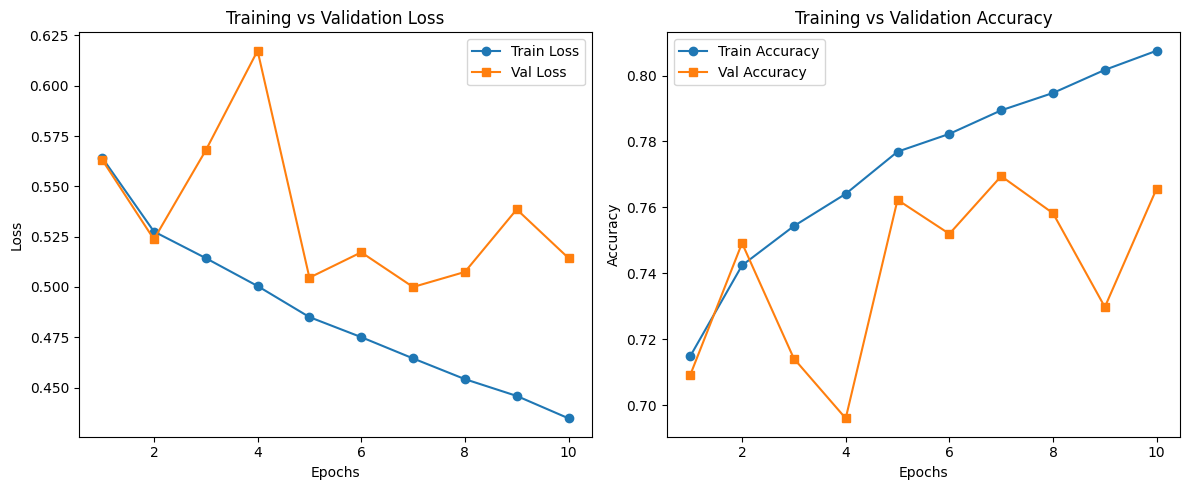

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define Loss & Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Parameters
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.round(torch.sigmoid(outputs))
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1).float()
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(valid_loader))
    val_accs.append(correct / total)

    # Print Epoch Summary
    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]*100:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]*100:.2f}%")

# Plot Training & Validation Metrics
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs+1), val_accs, label="Val Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


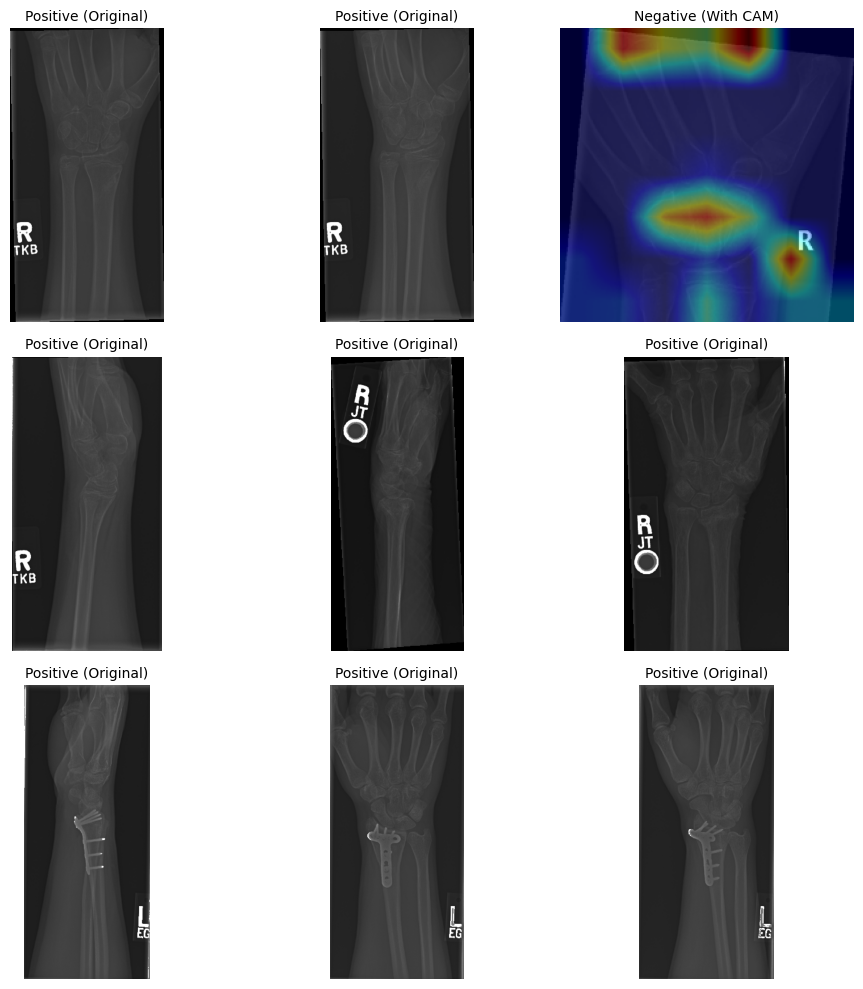

In [9]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

# Define function to compute CAM
def compute_cam(model, img_tensor, layer_name="layer4"):
    model.eval()
    
    feature_maps = None
    def hook_fn(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    # Hook the selected layer
    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        output = model(img_tensor)

    handle.remove()

    # Get predicted class
    predicted_class = torch.round(torch.sigmoid(output)).item()

    if predicted_class == 1:  # Positive case, return original image
        return None, predicted_class

    # Get weight of final layer
    weights = model.fc.weight.detach().cpu().numpy()

    # Compute CAM
    cam = np.zeros(feature_maps.shape[2:], dtype=np.float32)
    for i in range(weights.shape[1]):
        cam += weights[0, i] * feature_maps[0, i].detach().cpu().numpy()

    # Normalize CAM
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    return heatmap, predicted_class

# Load first 9 validation images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
    img_path = valid_paths.iloc[i, 0]
    img = Image.open(img_path).convert("RGB")

    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Get CAM or original image
    cam, predicted_class = compute_cam(model, img_tensor)

    # Convert original image for visualization
    img_np = np.array(img.resize((224, 224)))
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    if cam is not None:  # If negative, apply CAM
        superimposed_img = cv2.addWeighted(img_np, 0.6, cam, 0.4, 0)
        axes[i // 3, i % 3].imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        axes[i // 3, i % 3].set_title("Negative (With CAM)", fontsize=10)
    else:  # If positive, show original
        axes[i // 3, i % 3].imshow(img)
        axes[i // 3, i % 3].set_title("Positive (Original)", fontsize=10)

    axes[i // 3, i % 3].axis("off")

plt.tight_layout()
plt.show()
